# 1. Environment setup

## 1.1 Install necessary packages

In [1]:
#!pip install pandas 
#!pip install matplotlib.pyplot 
#!pip install seaborn 
#!pip install statsmodels 
#!pip install import-ipynb

## 1.2 Import package

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor


In [3]:
import import_ipynb
from utils.Usefull_functions import create_lagged_features
from utils.Usefull_functions import flatten_prediction_list

# 2. Data preprocessing

## 2.1 Import and merge dataframes

In [4]:
#import files
hist_features = pd.read_csv("History/History_Features.csv", sep=';')
hist_target = pd.read_csv("History/History_Targets.csv", sep=';')

# merge dataframes
df = pd.merge(hist_features, hist_target, on="Year")
df = df.set_index("Year")
df

,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE
Year,,,,,,
2014,32.76,20.92,5.94,74.96,242,99.73
2015,31.63,19.80,7.63,55.88,238,100.65
2016,28.98,14.01,5.29,59.20,240,102.15
2017,34.19,17.30,5.75,83.07,240,105.38
2018,44.47,22.80,15.72,91.64,239,106.31
2019,37.67,13.55,24.70,62.27,229,103.87
2020,30.47,9.40,24.62,51.43,217,95.91
2021,96.85,46.36,52.85,116.08,225,99.33
2022,235.45,122.88,79.89,277.45,212,98.70


## 2.2 Visualization and description of raw data

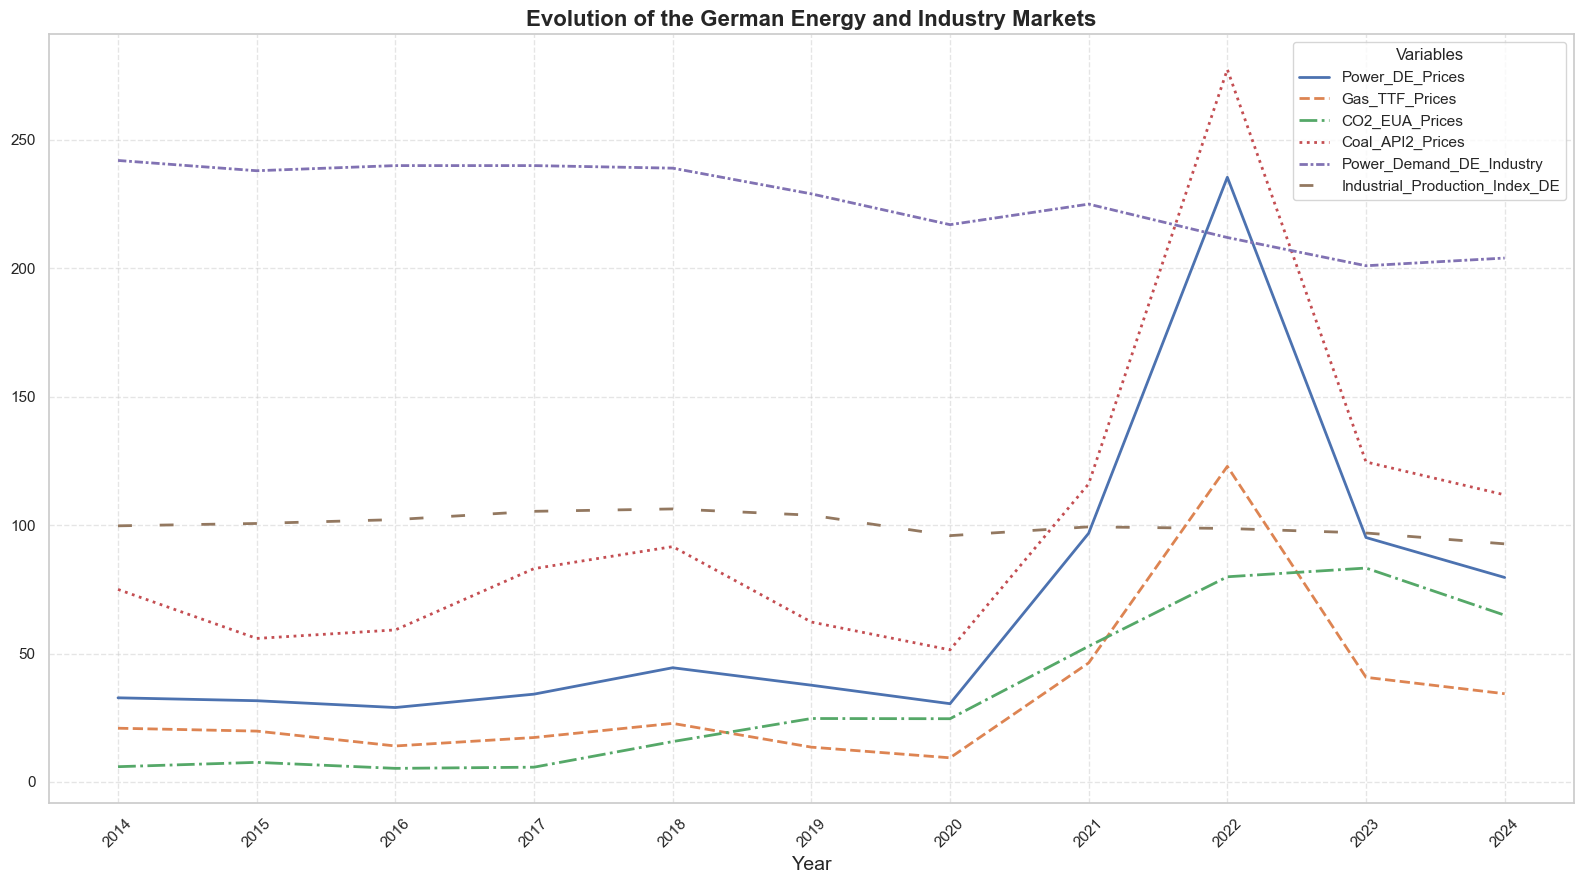

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))

line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]  

for idx, col in enumerate(df):
    style = line_styles[idx % len(line_styles)]
    plt.plot(df.index, df[col], label=col, linewidth=2, linestyle=style)

plt.title("Evolution of the German Energy and Industry Markets", 
          fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.xticks(df.index, rotation=45)
plt.legend(title="Variables", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [6]:
df.describe()

,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,67.933636,32.919091,33.692727,100.760909,226.090909,100.152727
std,61.528802,32.070455,30.758192,63.923542,15.352228,4.122783
min,28.980000,9.400000,5.290000,51.430000,201.000000,92.710000
25%,32.195000,15.655000,6.785000,60.735000,214.500000,97.820000
50%,37.670000,20.920000,24.620000,83.070000,229.000000,99.730000
75%,87.400000,37.545000,58.895000,113.935000,239.500000,103.010000
max,235.450000,122.880000,83.290000,277.450000,242.000000,106.310000


#### Obsevations: No clear outliers in data. However large differences in mean and std among variables, which make correlations between targets and features unclear -> Need to standardize data!

## 2.3 Standardsation of data

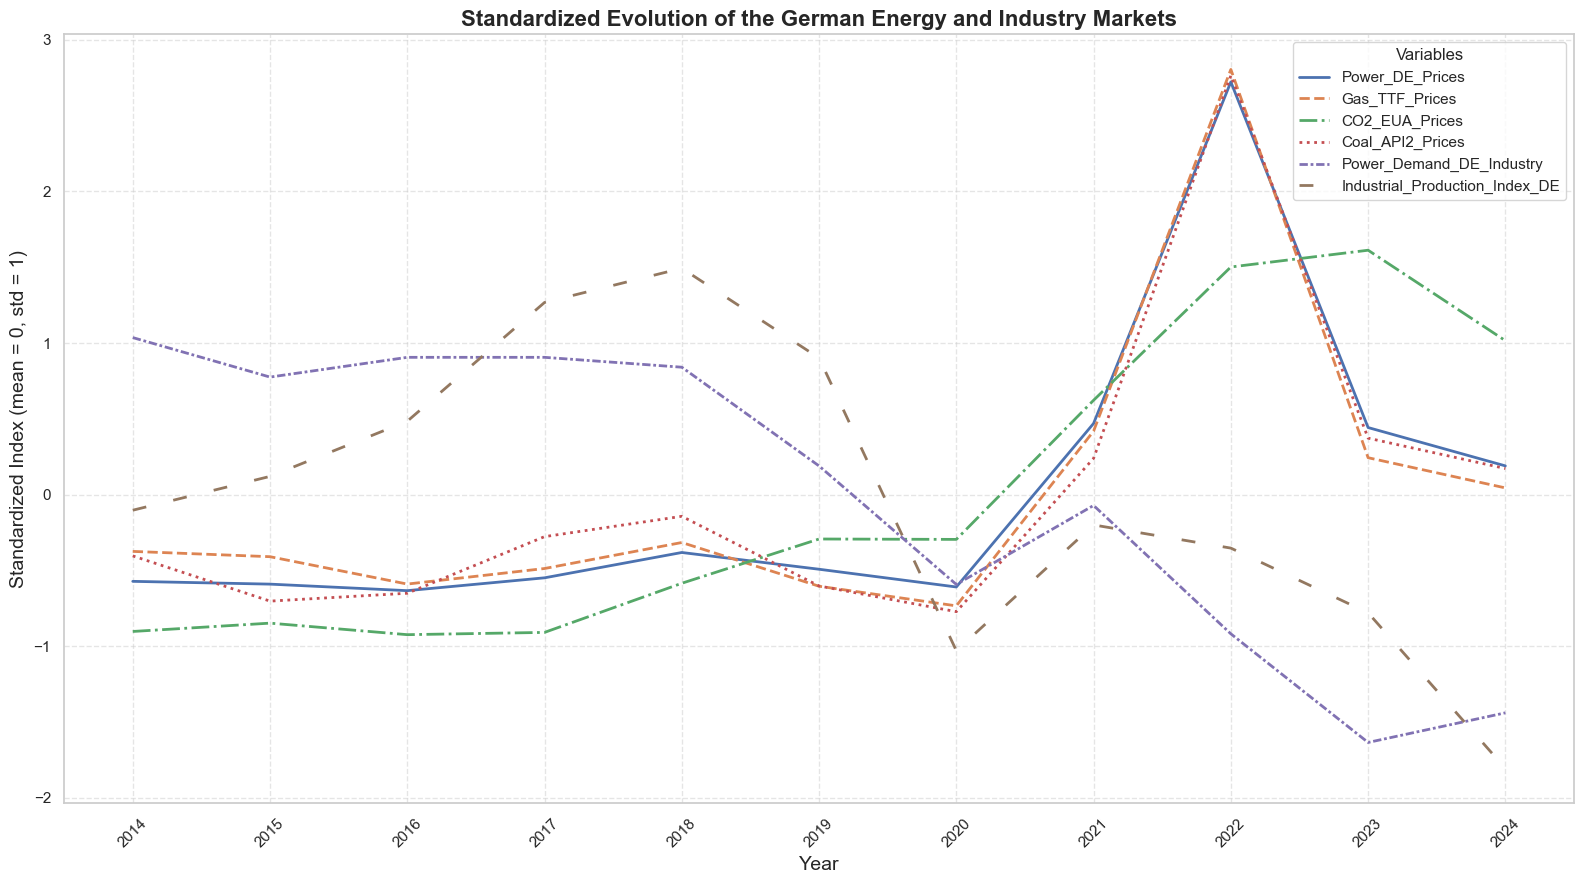

In [7]:
df_standardized = df.copy()

for col in df:
    mean = df[col].mean()
    std = df[col].std()
    df_standardized[col] = (df[col] - mean) / std
    
sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))

line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))] 

for idx, col in enumerate(df_standardized):
    style = line_styles[idx % len(line_styles)]
    plt.plot(df_standardized.index, df_standardized[col], label=col, linewidth=2, linestyle=style)

plt.title("Standardized Evolution of the German Energy and Industry Markets", 
          fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Standardized Index (mean = 0, std = 1)", fontsize=14)
plt.xticks(df_standardized.index, rotation=45)
plt.legend(title="Variables", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

#### Obsevation: Some correlations arise but data seem to be not stationnary -> Augmented Dickey-Fuller test to make sure 

## 2.4 Stationarity test and final preproccessing steps

In [8]:
def adf(data):
    results = []
    for col in data.columns:
        series = data[col].dropna()
        p_value = adfuller(series)[1]
        results.append({"Variable": col, "ADF p-value": p_value})
    return pd.DataFrame(results).set_index("Variable").sort_values("ADF p-value")
adf(df_standardized)

,ADF p-value
Variable,
Gas_TTF_Prices,0.250494
CO2_EUA_Prices,0.493774
Industrial_Production_Index_DE,0.853629
Power_Demand_DE_Industry,0.919352
Coal_API2_Prices,0.998486
Power_DE_Prices,1.000000


#### Obsevation: stationnarity issue confirmed -> take y-o-y difference to make it stationnary

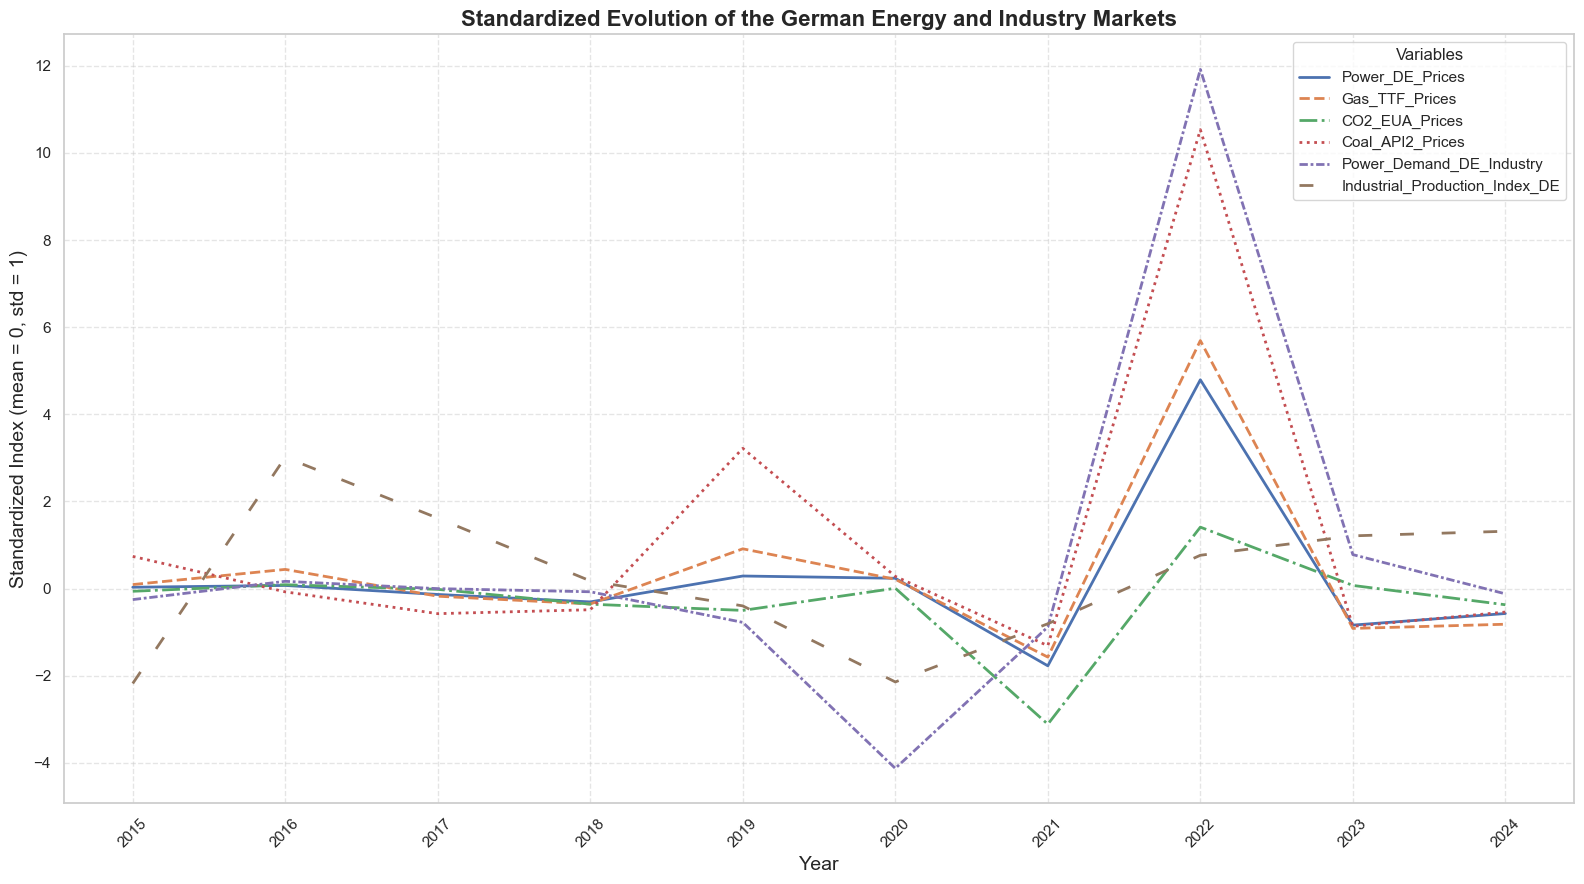

In [9]:
df_analysis = df_standardized.pct_change(1).iloc[1:]

sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))

line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]  

for idx, col in enumerate(df_analysis):
    style = line_styles[idx % len(line_styles)]
    plt.plot(df_analysis.index, df_analysis[col], label=col, linewidth=2, linestyle=style)

plt.title("Standardized Evolution of the German Energy and Industry Markets", 
          fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Standardized Index (mean = 0, std = 1)", fontsize=14)
plt.xticks(df_analysis.index, rotation=45)
plt.legend(title="Variables", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [10]:
def adf(data):
    results = []
    for col in data.columns:
        series = data[col].dropna()
        p_value = adfuller(series)[1]
        results.append({"Variable": col, "ADF p-value": p_value})
    return pd.DataFrame(results).set_index("Variable").sort_values("ADF p-value")
adf(df_analysis)

,ADF p-value
Variable,
Industrial_Production_Index_DE,0.000000e+00
Power_Demand_DE_Industry,1.270904e-12
CO2_EUA_Prices,6.242516e-04
Coal_API2_Prices,9.939086e-01
Power_DE_Prices,9.978879e-01
Gas_TTF_Prices,9.981144e-01


#### Obsevation: data is now stationnary and ready for analysis

# 3 Analysis

In [11]:
#Plot correlation matrix
corr = df_analysis.corr()
corr.style.background_gradient(cmap='coolwarm')\
    .set_table_attributes("style='display:inline; font-size:11px'")

,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE
Power_DE_Prices,1.000000,0.992548,0.734914,0.958830,0.855354,0.081517
Gas_TTF_Prices,0.992548,1.000000,0.680853,0.976703,0.857617,0.082749
CO2_EUA_Prices,0.734914,0.680853,1.000000,0.575781,0.519176,0.261552
Coal_API2_Prices,0.958830,0.976703,0.575781,1.000000,0.862854,-0.003480
Power_Demand_DE_Industry,0.855354,0.857617,0.519176,0.862854,1.000000,0.304977
Industrial_Production_Index_DE,0.081517,0.082749,0.261552,-0.003480,0.304977,1.000000


## 3.1 Choose Best Explanatory Varibales and Lags

In [12]:
#use Lasso regression to get best set of varibales adn lags
targets = ["Power_Demand_DE_Industry", "Industrial_Production_Index_DE"]

for target in targets :   
    
    
    df_lagged = create_lagged_features(df_analysis, target_col = target, max_lag=3)
    
    
    X = df_lagged.drop(columns=[target])
    y = df_lagged[target]

    
    lasso = LassoCV(cv=7, random_state=0)
    lasso.fit(X, y)

    
    coef = pd.Series(lasso.coef_, index=X.columns)

   
    important_lags = coef.abs().sort_values(ascending=False).head(10)
    print(f"Top 10 lags by importance (Lasso) for {target} :\n", important_lags)

Top 10 lags by importance (Lasso) for Power_Demand_DE_Industry :
 Coal_API2_Prices                       1.074640
Industrial_Production_Index_DE_lag3    0.898683
Industrial_Production_Index_DE_lag2    0.067110
Coal_API2_Prices_lag2                  0.057104
CO2_EUA_Prices_lag1                    0.000000
Industrial_Production_Index_DE_lag1    0.000000
Coal_API2_Prices_lag3                  0.000000
Coal_API2_Prices_lag1                  0.000000
CO2_EUA_Prices_lag3                    0.000000
CO2_EUA_Prices_lag2                    0.000000
dtype: float64
Top 10 lags by importance (Lasso) for Industrial_Production_Index_DE :
 Power_Demand_DE_Industry         0.118958
Power_Demand_DE_Industry_lag1    0.089542
Power_Demand_DE_Industry_lag2    0.083173
Power_DE_Prices                  0.000000
CO2_EUA_Prices_lag1              0.000000
Coal_API2_Prices_lag3            0.000000
Coal_API2_Prices_lag2            0.000000
Coal_API2_Prices_lag1            0.000000
CO2_EUA_Prices_lag3            

#### Observations : As suggested by the covariance matrix, Industrial_Production_Index is impacted by energy prices through Power_Demand_DE_Industry. Consequently, we will start by forecasting Power_Demand_DE_Industry and then use it to forecast Industrial_Production_Index

In [13]:
# Define your selected features
selected_features_power = [
    'Coal_API2_Prices',
    'Industrial_Production_Index_DE_lag2',
    'Coal_API2_Prices_lag2', 
]

selected_features_prod = [
    'Power_Demand_DE_Industry',
    'Power_Demand_DE_Industry_lag1',
    'Power_Demand_DE_Industry_lag2',
]

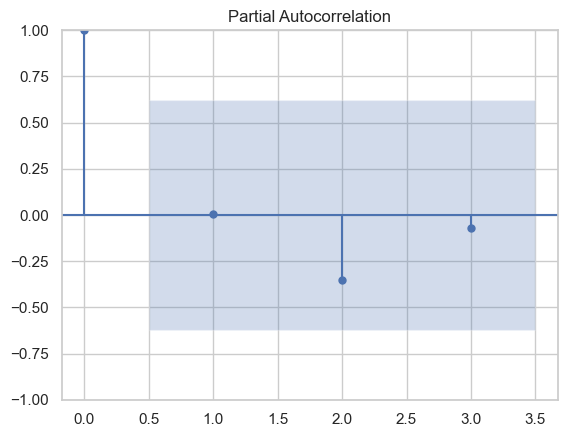

PACF for Power_Demand_DE_Industry


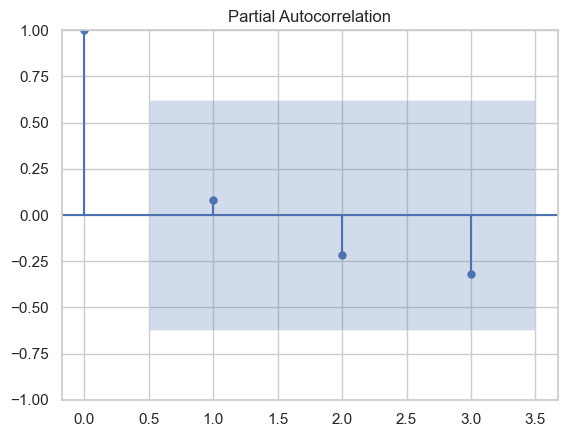

PACF for Industrial_Production_Index_DE


In [14]:
for target in targets :   
    plot_pacf(df_analysis[target].dropna(), lags=3)
    plt.show()
    print(f"PACF for {target}")

#### Observations : Take lag2 for Power_Demand_DE; Lag2 and Lag3 for Industrial_Production_Index_DE

## 3.1 Run estimations and forecating


In [15]:
fore_features = pd.read_csv("Forecast/Foecast_Features.csv", sep=';')
complete_data = pd.concat([pd.merge(hist_features, hist_target, on="Year"), fore_features], axis=0).set_index("Year")

complete_data_process = complete_data.copy()

for col in df:
    mean = complete_data[col].mean()
    std = complete_data[col].std()
    complete_data_process[col] = (complete_data[col] - mean) / std
    
complete_data_process = complete_data_process.pct_change(1).iloc[1:]
complete_data_process

C:\Users\benjamin.lietti\AppData\Local\Temp\ipykernel_17820\468625283.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  complete_data_process = complete_data_process.pct_change(1).iloc[1:]


,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE
Year,,,,,,
2015,0.026808,0.114148,-0.027096,0.581015,-0.251429,-2.176344
2016,0.061227,0.529647,0.038563,-0.063946,0.167939,3.016453
2017,-0.113430,-0.196749,-0.007299,-0.491161,0.000000,1.617205
2018,-0.252447,-0.409475,-0.159366,-0.346555,-0.071895,0.177913
2019,0.223380,1.166189,-0.170753,1.817553,-0.774648,-0.396279
2020,0.193333,0.241534,0.001834,0.238090,-4.125000,-2.141355
2021,-1.493654,-1.732623,-0.646137,-1.146905,-0.880000,-0.806085
2022,6.317621,4.896283,-1.748978,19.486991,11.916667,0.765746
2023,-0.873746,-0.891390,0.293621,-0.900968,0.780645,1.211514


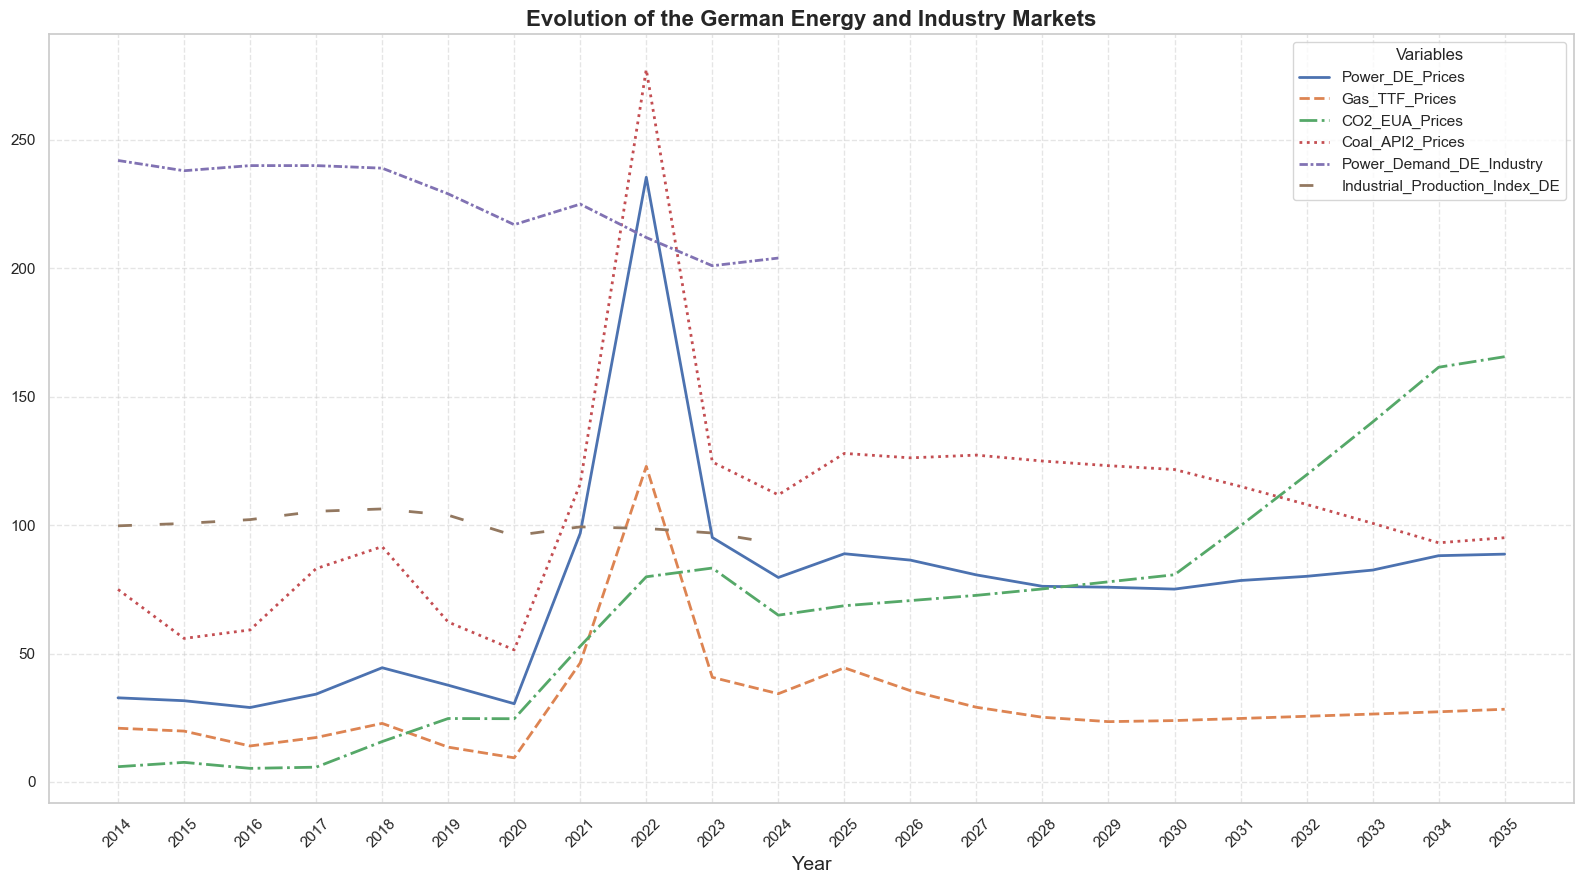

In [16]:
df_analysis = complete_data.copy()

sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))

line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))] 

for idx, col in enumerate(df_analysis):
    style = line_styles[idx % len(line_styles)]
    plt.plot(df_analysis.index, df_analysis[col], label=col, linewidth=2, linestyle=style)

plt.title("Evolution of the German Energy and Industry Markets", 
          fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xticks(df_analysis.index, rotation=45)
plt.legend(title="Variables", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

### 3.1.1 Simple OLS

In [17]:
results_ols = complete_data_process.copy()

pred_power =[]
ci_l_power = []
ci_u_power = []

pred_prod =[]
ci_l_prod = []
ci_u_prod = []

targets = ["Power_Demand_DE_Industry", "Industrial_Production_Index_DE"]

for i in results_ols.index: 
    for target in targets :   
        
        if i < 2024 : 
            continue
        
        # Create new dataframe with lags of all variables (up to 2 due to small amount of historical data)
        df_lagged = create_lagged_features(results_ols, target_col = None, max_lag=2)
        

        if target == "Power_Demand_DE_Industry":
            X = df_lagged[selected_features_power+ ['Power_Demand_DE_Industry_lag2']].loc[:2024]
            y = df_lagged[target].loc[:2024]
        
        if target == "Industrial_Production_Index_DE":
            X = df_lagged[selected_features_prod+ ['Industrial_Production_Index_DE_lag2']].loc[:2024]
            y = df_lagged[target].loc[:2024]
        
        # Add constant term for intercept
        X_sm = sm.add_constant(X)

        # Fit OLS model
        model_sm = sm.OLS(y, X_sm).fit()
        
        if i == 2024 : 
            # Show summary
            print(model_sm.summary())
            
        if i > 2024 :
            # Split into X and y
            if target == "Power_Demand_DE_Industry":
                X = df_lagged[selected_features_power+ ['Power_Demand_DE_Industry_lag2']].loc[[i]]
                X_sm = sm.add_constant(X, has_constant='add')
        
            if target == "Industrial_Production_Index_DE":
                X = df_lagged[selected_features_prod+ ['Industrial_Production_Index_DE_lag2']].loc[[i]]
                X_sm = sm.add_constant(X, has_constant='add')
      
        
        
        #Generate predictions and confidence intervals
        pred_results = model_sm.get_prediction(X_sm)
        pred_summary = pred_results.summary_frame(alpha=0.05)  # 95% CI

        # Extract predicted mean and confidence bounds
        if target == "Power_Demand_DE_Industry":
            pred_power.append(pred_summary['mean'])
            ci_l_power.append(pred_summary['mean_ci_lower'])
            ci_u_power.append(pred_summary['mean_ci_upper'])
        if target == "Industrial_Production_Index_DE":
            pred_prod.append(pred_summary['mean'])
            ci_l_prod.append(pred_summary['mean_ci_lower'])
            ci_u_prod.append(pred_summary['mean_ci_upper'])
        
        if i > 2024 : 
            results_ols[target][i] = pred_summary['mean']

                               OLS Regression Results                               
Dep. Variable:     Power_Demand_DE_Industry   R-squared:                       0.888
Model:                                  OLS   Adj. R-squared:                  0.739
Method:                       Least Squares   F-statistic:                     5.956
Date:                      Tue, 08 Jul 2025   Prob (F-statistic):             0.0872
Time:                              14:37:55   Log-Likelihood:                -14.454
No. Observations:                         8   AIC:                             38.91
Df Residuals:                             3   BIC:                             39.31
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

C:\Users\benjamin.lietti\Python310\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\benjamin.lietti\Python310\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\benjamin.lietti\AppData\Local\Temp\ipykernel_17820\687918751.py:68: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a Dat

In [18]:
results_ols['pred_power'] = pd.concat(pred_power)
results_ols['ci_l_power'] = pd.concat(ci_l_power)
results_ols['ci_u_power'] = pd.concat(ci_u_power)

results_ols['pred_prod'] =  pd.concat(pred_prod)
results_ols['ci_l_prod'] = pd.concat(ci_l_prod)
results_ols['ci_u_prod'] = pd.concat(ci_u_prod)

results_ols

,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE,pred_power,ci_l_power,ci_u_power,pred_prod,ci_l_prod,ci_u_prod
Year,,,,,,,,,,,,
2015,0.026808,0.114148,-0.027096,0.581015,-0.251429,-2.176344,NaN,NaN,NaN,NaN,NaN,NaN
2016,0.061227,0.529647,0.038563,-0.063946,0.167939,3.016453,NaN,NaN,NaN,NaN,NaN,NaN
2017,-0.113430,-0.196749,-0.007299,-0.491161,0.000000,1.617205,-0.638961,-6.234516,4.956594,0.217389,-2.441402,2.876181
2018,-0.252447,-0.409475,-0.159366,-0.346555,-0.071895,0.177913,-1.426466,-7.481965,4.629032,-0.545088,-3.696901,2.606726
2019,0.223380,1.166189,-0.170753,1.817553,-0.774648,-0.396279,-0.426205,-5.193995,4.341585,-0.460631,-2.521189,1.599927
2020,0.193333,0.241534,0.001834,0.238090,-4.125000,-2.141355,-1.001219,-4.889622,2.887185,-0.796097,-3.191560,1.599366
2021,-1.493654,-1.732623,-0.646137,-1.146905,-0.880000,-0.806085,0.024047,-7.249861,7.297956,-0.734514,-3.133983,1.664955
2022,6.317621,4.896283,-1.748978,19.486991,11.916667,0.765746,11.757128,4.122143,19.392113,1.219658,-2.586449,5.025764
2023,-0.873746,-0.891390,0.293621,-0.900968,0.780645,1.211514,-1.315744,-5.538553,2.907066,1.365987,-2.429814,5.161789


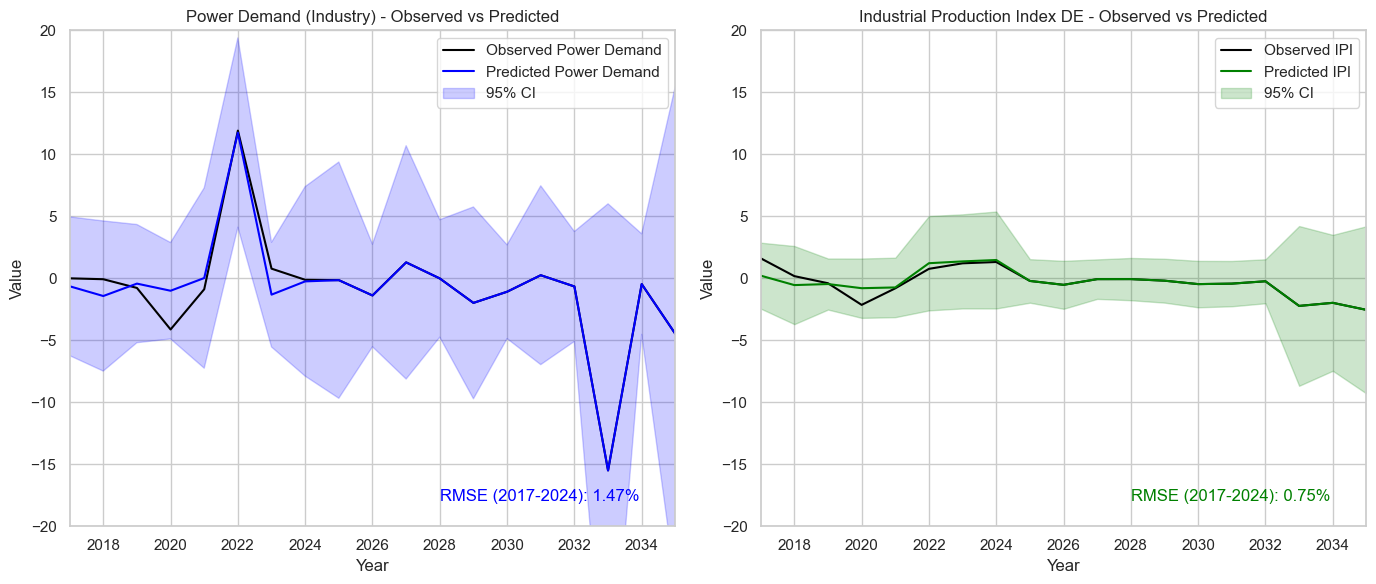

In [19]:
# Filter 2017-2024
mask = (results_ols.index >= 2017) & (results_ols.index <= 2024)

# Observed & predicted for Power Demand
obs_power = results_ols.loc[mask, 'Power_Demand_DE_Industry']
pred_power = results_ols.loc[mask, 'pred_power']

# Observed & predicted for Industrial Production Index
obs_prod = results_ols.loc[mask, 'Industrial_Production_Index_DE']
pred_prod = results_ols.loc[mask, 'pred_prod']

# RMSE 
rmse_power_abs = np.sqrt(np.mean((obs_power - pred_power)**2))
rmse_prod_abs = np.sqrt(np.mean((obs_prod - pred_prod)**2))


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(results_ols.index, results_ols['Power_Demand_DE_Industry'], label='Observed Power Demand', color='black')
plt.plot(results_ols.index, results_ols['pred_power'], label='Predicted Power Demand', color='blue')
plt.fill_between(results_ols.index, results_ols['ci_l_power'], results_ols['ci_u_power'], color='blue', alpha=0.2, label='95% CI')
plt.title('Power Demand (Industry) - Observed vs Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.ylim(-20, 20)
plt.xlim(2017, 2035)
plt.text(2028, -18, f'RMSE (2017-2024): {rmse_power_abs:.2f}%', fontsize=12, color='blue')


plt.subplot(1, 2, 2)
plt.plot(results_ols.index, results_ols['Industrial_Production_Index_DE'], label='Observed IPI', color='black')
plt.plot(results_ols.index, results_ols['pred_prod'], label='Predicted IPI', color='green')
plt.fill_between(results_ols.index, results_ols['ci_l_prod'], results_ols['ci_u_prod'], color='green', alpha=0.2, label='95% CI')
plt.title('Industrial Production Index DE - Observed vs Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.ylim(-20, 20)
plt.xlim(2017, 2035)

plt.text(2028, -18, f'RMSE (2017-2024): {rmse_prod_abs:.2f}%', fontsize=12, color='green')

plt.tight_layout()
plt.show()



### 3.1.2 Random Forest

In [20]:
results_rf = complete_data.fillna(0).copy()

pred_power =[]
ci_l_power = []
ci_u_power = []

pred_prod =[]
ci_l_prod = []
ci_u_prod = []

targets = ["Power_Demand_DE_Industry", "Industrial_Production_Index_DE"]

for i in results_rf.index: 
    for target in targets :   
        if i < 2024 : 
            continue
        
        # Create new dataframe with lags of all variables (up to 2 due to small amount of historical data)
        df_lagged = create_lagged_features(results_rf, target_col = None, max_lag=2)
        df_lagged['time']=df_lagged.index


        if target == "Power_Demand_DE_Industry":
            X = df_lagged[selected_features_power+ ['Power_Demand_DE_Industry_lag2']].loc[:2024]
            y = df_lagged[target].loc[:2024]
        
        if target == "Industrial_Production_Index_DE":
            X = df_lagged[selected_features_prod+ ['Industrial_Production_Index_DE_lag2']].loc[:2024]
            y = df_lagged[target].loc[:2024]
        

        # Fit Random Forest model
        model_rf = RandomForestRegressor(n_estimators=500, random_state=0, max_depth=5)
        model_rf.fit(X.loc[:2022], y.loc[:2022])
        
           
        if i > 2024 :
            # Split into X and y
            if target == "Power_Demand_DE_Industry":
                X = df_lagged[selected_features_power+ ['Power_Demand_DE_Industry_lag2']].loc[[i]]
                
        
            if target == "Industrial_Production_Index_DE":
                X = df_lagged[selected_features_prod+ ['Industrial_Production_Index_DE_lag2']].loc[[i]]
                
      
        
        
        # Generate prediction
        pred = model_rf.predict(X)

        # Estimate confidence intervals using the standard deviation of predictions from all trees
        all_preds = [tree.predict(X)[0] for tree in model_rf.estimators_]
        std_pred = pd.Series(all_preds).std()
        ci_lower = pred - 1.96 * std_pred
        ci_upper = pred + 1.96 * std_pred

        # Wrap as pandas Series for compatibility
        pred_series = pd.Series([pred], index=[i])
        ci_lower_series = pd.Series([ci_lower], index=[i])
        ci_upper_series = pd.Series([ci_upper], index=[i])

        if target == "Power_Demand_DE_Industry":
            pred_power.append(pred_series)
            ci_l_power.append(ci_lower_series)
            ci_u_power.append(ci_upper_series)
        if target == "Industrial_Production_Index_DE":
            pred_prod.append(pred_series)
            ci_l_prod.append(ci_lower_series)
            ci_u_prod.append(ci_upper_series)

        if i > 2024:
            results_rf[target][i] = pred

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\AppData\Local\Temp\ipykernel_17820\2477726169.py:73: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results_rf[target][i] = pred
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\benjamin.lietti\Python310\lib\site-packages\sklearn\base.py:486: UserWa

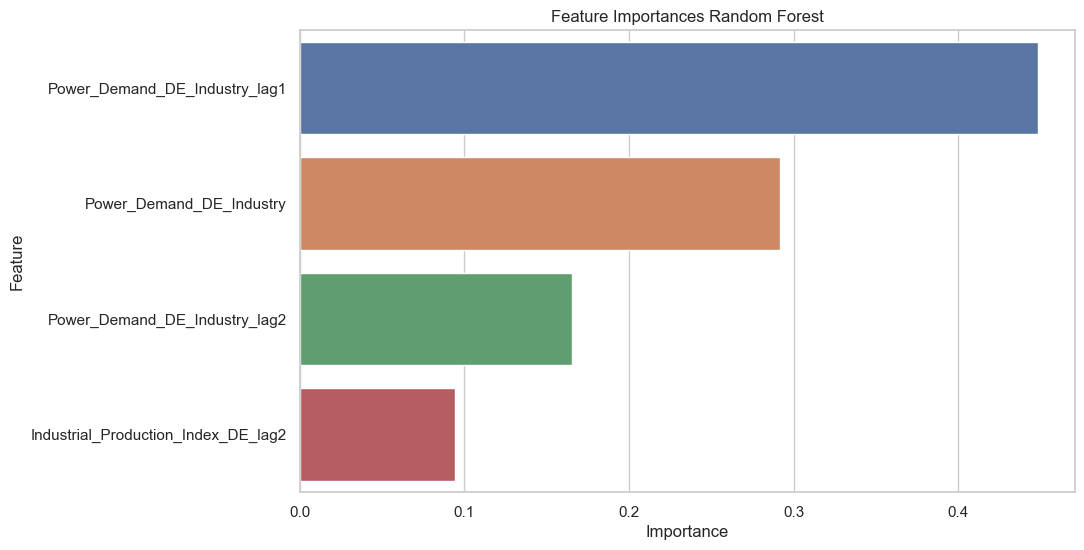

In [21]:
importances = model_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances Random Forest')
plt.show()

In [22]:
results_rf['pred_power'] = flatten_prediction_list(pred_power)
results_rf['ci_l_power'] = flatten_prediction_list(ci_l_power)
results_rf['ci_u_power'] = flatten_prediction_list(ci_u_power)

results_rf['pred_prod'] = flatten_prediction_list(pred_prod)
results_rf['ci_l_prod'] = flatten_prediction_list(ci_l_prod)
results_rf['ci_u_prod'] = flatten_prediction_list(ci_u_prod)
results_rf

,Power_DE_Prices,Gas_TTF_Prices,CO2_EUA_Prices,Coal_API2_Prices,Power_Demand_DE_Industry,Industrial_Production_Index_DE,pred_power,ci_l_power,ci_u_power,pred_prod,ci_l_prod,ci_u_prod
Year,,,,,,,,,,,,
2014,32.76,20.92,5.94,74.96,242.000,99.73000,NaN,NaN,NaN,NaN,NaN,NaN
2015,31.63,19.80,7.63,55.88,238.000,100.65000,NaN,NaN,NaN,NaN,NaN,NaN
2016,28.98,14.01,5.29,59.20,240.000,102.15000,237.396,226.533884,248.258116,103.21054,100.163601,106.257479
2017,34.19,17.30,5.75,83.07,240.000,105.38000,235.774,224.911884,246.636116,104.62054,101.573601,107.667479
2018,44.47,22.80,15.72,91.64,239.000,106.31000,237.540,226.677884,248.402116,105.63062,102.583681,108.677559
2019,37.67,13.55,24.70,62.27,229.000,103.87000,229.242,218.379884,240.104116,103.31174,100.264801,106.358679
2020,30.47,9.40,24.62,51.43,217.000,95.91000,222.506,211.643884,233.368116,97.92872,94.881781,100.975659
2021,96.85,46.36,52.85,116.08,225.000,99.33000,227.068,216.205884,237.930116,99.43874,96.391801,102.485679
2022,235.45,122.88,79.89,277.45,212.000,98.70000,220.618,209.755884,231.480116,98.55792,95.510981,101.604859


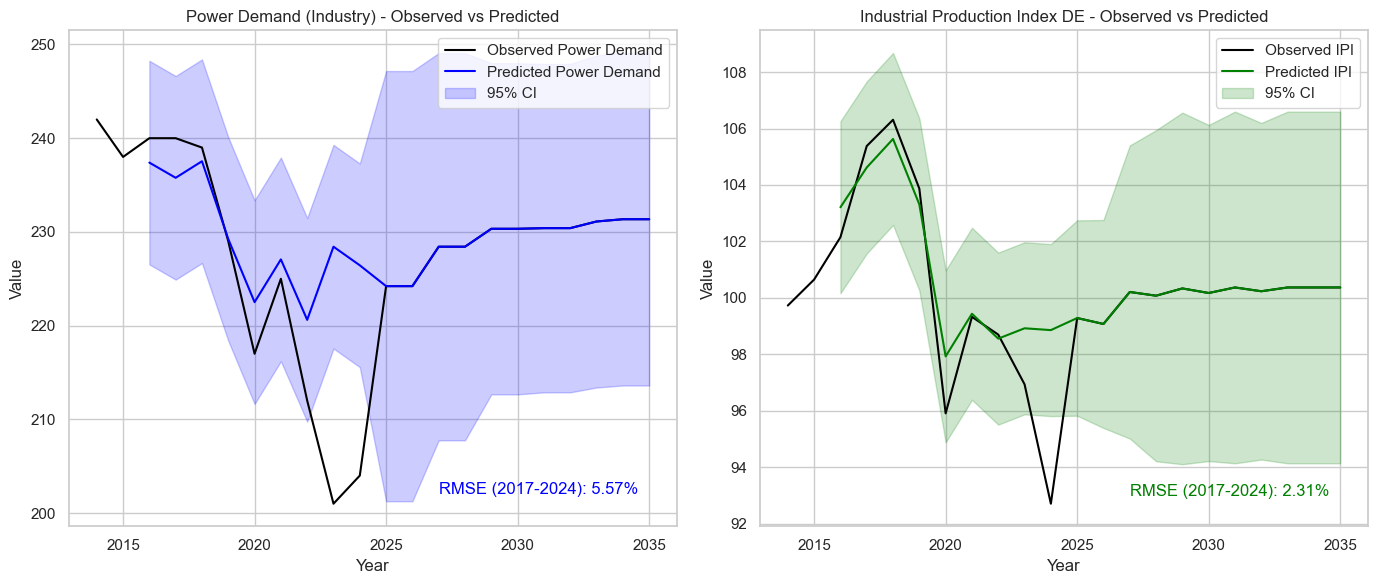

In [23]:
# Filter 2016-2024
mask = (results_rf.index >= 2016) & (results_rf.index <= 2024)

# Observed & predicted for Power Demand
obs_power = results_rf.loc[mask, 'Power_Demand_DE_Industry']
pred_power = results_rf.loc[mask, 'pred_power']

# Observed & predicted for Industrial Production Index
obs_prod = results_rf.loc[mask, 'Industrial_Production_Index_DE']
pred_prod = results_rf.loc[mask, 'pred_prod']

# RMSE absolute
rmse_power_abs = np.sqrt(np.mean((obs_power - pred_power)**2))
rmse_prod_abs = np.sqrt(np.mean((obs_prod - pred_prod)**2))

rmse_power_pct = 100 * rmse_power_abs / obs_power.mean()
rmse_prod_pct = 100 * rmse_prod_abs / obs_prod.mean()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(results_rf.index, results_rf['Power_Demand_DE_Industry'], label='Observed Power Demand', color='black')
plt.plot(results_rf.index, results_rf['pred_power'], label='Predicted Power Demand', color='blue')
plt.fill_between(results_rf.index, results_rf['ci_l_power'], results_rf['ci_u_power'], color='blue', alpha=0.2, label='95% CI')
plt.title('Power Demand (Industry) - Observed vs Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.text(2027, 202, f'RMSE (2017-2024): {rmse_power_pct:.2f}%', fontsize=12, color='blue')

plt.subplot(1, 2, 2)
plt.plot(results_rf.index, results_rf['Industrial_Production_Index_DE'], label='Observed IPI', color='black')
plt.plot(results_rf.index, results_rf['pred_prod'], label='Predicted IPI', color='green')
plt.fill_between(results_rf.index, results_rf['ci_l_prod'], results_rf['ci_u_prod'], color='green', alpha=0.2, label='95% CI')
plt.title('Industrial Production Index DE - Observed vs Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.text(2027, 93, f'RMSE (2017-2024): {rmse_prod_pct:.2f}%', fontsize=12, color='green')

plt.tight_layout()
plt.show()

# 4 Additional data

In [24]:
complete_data[['Power_Demand_DE_Industry', 'Industrial_Production_Index_DE']]

,Power_Demand_DE_Industry,Industrial_Production_Index_DE
Year,,
2014,242.0,99.73
2015,238.0,100.65
2016,240.0,102.15
2017,240.0,105.38
2018,239.0,106.31
2019,229.0,103.87
2020,217.0,95.91
2021,225.0,99.33
2022,212.0,98.70


In [25]:
data_cement = pd.read_csv('sat_monthly_itpl.csv', parse_dates=['datem'])
data_cement = data_cement.set_index('datem')['Germany']
data_cement = data_cement.resample('Y').mean()
data_cement.index = data_cement.index.year
data_cement = data_cement.reset_index()
data_cement.columns = ['Year', 'Germany_Cement_Prod']
data_cement = data_cement.set_index('Year')
data_cement

C:\Users\benjamin.lietti\AppData\Local\Temp\ipykernel_17820\3586439054.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_cement = data_cement.resample('Y').mean()


,Germany_Cement_Prod
Year,
2015,0.689482
2016,0.593859
2017,0.616441
2018,0.661481
2019,0.626256
2020,0.624331
2021,0.592615
2022,0.599424
2023,0.531890


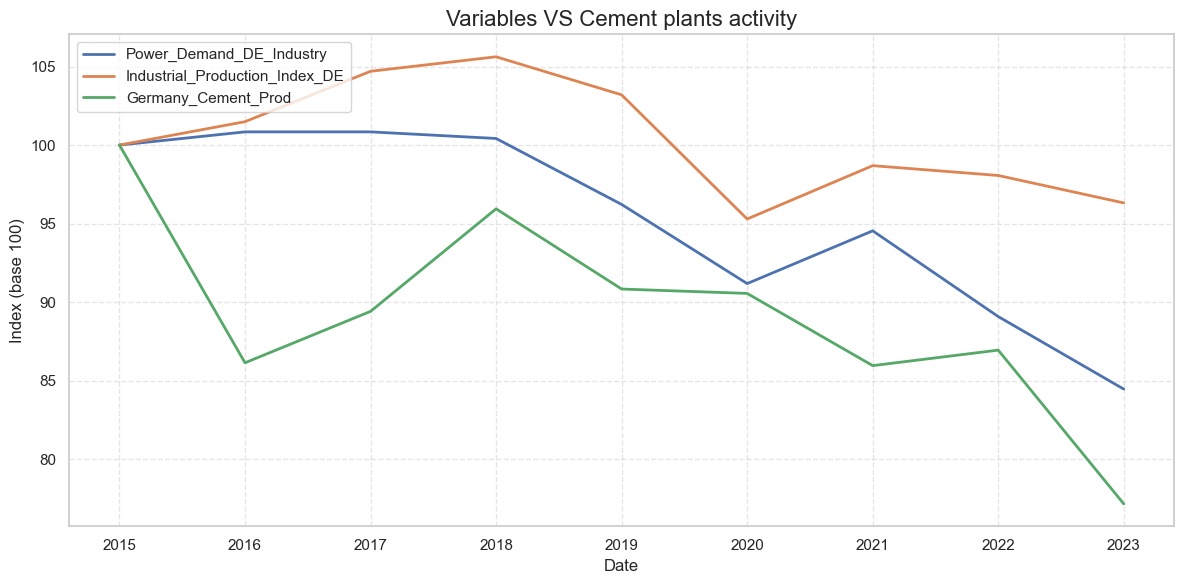

In [26]:
all_data = pd.merge(complete_data[['Power_Demand_DE_Industry', 'Industrial_Production_Index_DE']],data_cement, on='Year', how='inner' )
rebased_data = all_data.iloc[:-1, :].copy()

for col in rebased_data.columns:
    first_valid = rebased_data[col].dropna().iloc[0]
    rebased_data[col] = (rebased_data[col] / first_valid) * 100
    
plt.figure(figsize=(12, 6))

for col in rebased_data.columns:
    plt.plot(rebased_data.index, rebased_data[col], label=col, linewidth=2)

plt.title('Variables VS Cement plants activity', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index (base 100)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()